# Visualizing and Breaking ConvNets
In this exercise we will visualize saliency maps for individual images and we will construct images to fool a trained ConvNet.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load the data and pretrained model
You should have already downloaded the TinyImageNet-100-A dataset and the pretrained models.

In [2]:
# Load the TinyImageNet-100-A dataset and a pretrained model

from cs231n.data_utils import load_tiny_imagenet, load_models

tiny_imagenet_a = 'cs231n/datasets/tiny-imagenet-100-A'
        
class_names, X_train, y_train, X_val, y_val, X_test, y_test = load_tiny_imagenet(tiny_imagenet_a)

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

# Load a pretrained model; it is a five layer convnet.
models_dir = 'cs231n/datasets/tiny-100-A-pretrained'
model = load_models(models_dir)['model2']

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# Compute predictions on validation set
For the experiments in this exercise it will be useful to have access to the predictions of the trained ConvNet on the TinyImageNet-100-A validation set.

In [3]:
from cs231n.classifiers.convnet import five_layer_convnet

# Array of shape (X_val.shape[0],) storing predictions on the validation set.
# y_val_pred[i] = c indicates that the model predicts that X_val[i] has label c.

################################################################################
# TODO: Use the pretrained model stored in model to compute predictions on the #
# validation set. Store the results in y_val_pred.                             #
#                                                                              #
# HINT: As in the previous exercises, you will want to break the validation    #
# set into batches.                                                            #
################################################################################
# Load a pretrained model; it is a five layer convnet.
models_dir = 'cs231n/datasets/tiny-100-A-pretrained'
model = load_models(models_dir)['model2']

N_val = X_val.shape[0]
batch = 100
n_val_iter = N_val / batch + ((N_val % batch) >0 )
y_val_pred = np.zeros((y_val.shape))
for i in xrange(n_val_iter):    
    y_val_pred[i*batch:(i+1)*batch] = np.argmax(five_layer_convnet(X = X_val[i*batch:(i+1)*batch], model = model, return_probs=True), axis=1)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

correct_indices, = np.nonzero(y_val_pred == y_val)

# Visualize Saliency Maps
In a recent paper [1], it was suggested that you can understand which part of an image is important for classification by visualizing the gradient of the correct class score with respect to the input image. This was covered in lecture on 2/2/2015 under the section "Visualize the data gradient". Recall that if a region of the image has a high data gradient, then this indicates that the output of the ConvNet is sensitive to perturbations in that region of the input image.

We will do something similar, instead visualizing the gradient of the data loss with respect to the input image; this gives similar results and is cleaner to implement using our codebase.

First, open the file `cs231n/classifiers/convnet.py` and modify the `five_layer_net` function to return the gradient of the loss with respect to the input when the `compute_dX` flag is true.

Once you have done so, complete the implementation in the following cell to allow you to visualize image-specific class saliency maps for images in the TinyImageNet-100-A validation set.

[1] K. Simonyan, A. Vedaldi, A. Zisserman , "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014

[628 649 705 775 934 955]


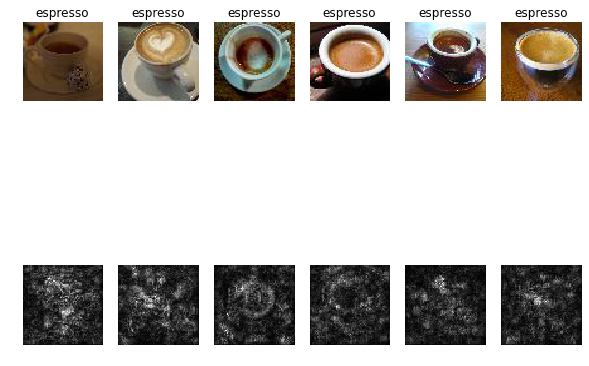

In [4]:
def show_image(img, rescale=False, add_mean=True):
    """
    Utility to show an image. In our ConvNets, images are 3D slices of 4D
    volumes; to visualize them we need to squeeze out the extra dimension,
    flip the axes so that channels are last, add the mean image, convert to
    uint8, and possibly rescale to be between 0 and 255. To make figures
    prettier we also need to suppress the axis labels after imshow.
    
    Input:
    - img: (1, C, H, W) or (C, H, W) or (1, H, W) or (H, W) giving
      pixel data for an image.
    - rescale: If true rescale the data to fit between 0 and 255
    - add_mean: If true add the training data mean image
    """
    img = img.copy()
    if add_mean:
        img += mean_img
    img = img.squeeze()
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)
    if rescale:
        low, high = np.min(img), np.max(img)
        img = 255.0 * (img - low) / (high - low)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# The number of example images to show. You can change this.
num_examples = 6

# The label of the class to visualize. You can change this.
class_idx = 8 # goldfish 22, sheshore 25, camel 27, table 12

# An array of shape (num_examples,) containing the indices of validation set
# images for which saliency maps will be visualized. We wil visualize several
# examples of images from the validation set whose label is class_idx and which
# are correctly classified using the pretrained ConvNet. In other words, if
# example_idxs[i] = j then we should have y_val[j] = class_idx and the pretrained
# ConvNet should correctly classify X_val[j].
example_idxs = None

################################################################################
# TODO: Choose several examples from the validation set whose correct label is #
# class_idx and which are correctly classified by the pretrained ConvNet.      #
# Store the results in the example_idxs variable.                              #
################################################################################
example_idxs = np.where((y_val == class_idx) & (y_val == y_val_pred))[0][0:num_examples]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Array to store gradients of the loss with respect to your chosen example images.
dX = np.zeros((num_examples, 3, 64, 64))

################################################################################
# TODO: Compute image gradients for your chosen examples. Store the result in  #
# the dX variable.                                                             #
################################################################################
dX = five_layer_convnet(X = X_val[example_idxs], model = model, y = y_val[example_idxs], compute_dX=True)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
print example_idxs
# Plot the images and their saliency maps.
for i in xrange(num_examples):
    # Visualize the image
    plt.subplot(2, num_examples, i + 1)
    
    show_image(X_val[example_idxs[i]])
    plt.title(class_names[y_val[example_idxs[i]]][0])
    
    # Saliency map for the ith example image.
    sal = np.zeros((64, 64))
    
    ############################################################################
    # TODO: Compute the saliency map for the ith example image. Use image      #
    # derivatives from dX[i] to compute the saliency map for                   #
    # X_val[example_idxs[i]]. Store the result in the sal variable.            #
    ############################################################################
    sal = np.max(np.abs(dX[i]), axis=0)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    
    # Visualize its saliency map.
    plt.subplot(2, num_examples, num_examples + i + 1)
    show_image(sal, rescale=True, add_mean=False)

# Fooling images for ConvNets
Two other papers [1, 2] discussed in lecture on 2/2 presented the idea of performing optimization over the input images to construct images that "fool" a trained ConvNet. This paper showed that given a trained ConvNet, an input image, and a desired label, that we can add a small amount of noise to the input image to force the ConvNet to classify it as having the desired label.

In this section we will reproduce some of these results.

Suppose that $L(x, y, m)$ is the data loss under model $m$, where we tell the network that the input $x$ should be classified as having label $y$. Given a starting image $x_0$, a desired label $y$, and a pretrained model $m$, we will create a fooling image $x_f$ by solving the following optimization problem:

$$x_f = \arg\min_x \left(L(x, y, m) + \frac\lambda2 \|x - x_0\|^2_2\right)$$

The term $\|x - x_0\|^2$ is $L_2$ regularization in image space which encourages the fooling image to look similar to the starting image, and the constant $\lambda$ is the strength of this regularization. We will use gradient descent to perform optimization under this model.

In the past, when using gradient descent we have stopped after a fixed number of iterations. Here we will use a different stopping criteria. Suppose that $p(x=y \mid m)$ is the probability that the input $x$ is assigned the label $y$ under the model $m$. We will specify a desired *confidence threshold* $t$ for the fooling image, and we will stop our optimization when we have $p(x_f=y\mid m) >= t$.

[1] Szegedy, Christian, et al. "Intriguing properties of neural networks." arXiv preprint, 2013.
<br>
[2] Nguyen, Anh, Jason Yosinski, and Jeff Clune. "Deep Neural Networks are Easily Fooled: High Confidence Predictions for Unrecognizable Images." arXiv preprint, 2014.

In [5]:
def make_fooling_image(img, y, model, reg=0.0, step_size=500, confidence=0.5):
    """
    Perform optimization in image space to create an image that is similar to img
    but is classified as y by model.
    
    Inputs:
    - img: Array of shape (1, C, H, W) containing (mean-subtracted) pixel data for
      the starting point for the fooling image.
    - y: The desired label; should be a single integer.
    - model: Dictionary mapping parameter names to weights; this is a pretrained
      five_layer_net model.
    - reg: Regularization strength (in image space) for the fooling image. This
      is the parameter lambda in the equation above.
    - step_size: The step size to use for gradient descent.
    - confidence: The desired confidence threshold for the fooling image.
    """
    fooling_img = img.copy()
    ################################################################################
    # TODO: Use gradient descent in image space to create a fooling image,         #
    # stopping when the predicted probability for the fooling image is greater     #
    # than the specified confidence threshold.                                     #
    ################################################################################
    while(True):
        grad = five_layer_convnet(X = fooling_img, model = model, y = y, compute_dX=True) + reg*(fooling_img - img)
        fooling_img -= step_size*grad
        pred_prob =  five_layer_convnet(X = fooling_img, model = model, return_probs=True).T
        print pred_prob[y], five_layer_convnet(X = fooling_img, model = model, y = y)[0]
        if pred_prob[y] >= confidence:
            print pred_prob[y]
            break
     
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
            
    return fooling_img

# Fooling images from correctly classified images
We will choose an image that is correctly classified by the pretrained network and create a fooling image that the network classifies as a goldfish.

You should experiment with different step sizes, regularizations, confidence thresholds, and target classes

[ 0.01154722] 4.46131086349
[ 0.01737755] 4.05257606506
[ 0.02564925] 3.66324090958
[ 0.0363389] 3.31486654282
[ 0.04966421] 3.00247073174
[ 0.06975352] 2.66278743744
[ 0.10114896] 2.29116106033
[ 0.14348382] 1.94153296947
[ 0.19394667] 1.6401720047
[ 0.25066441] 1.38364028931
[ 0.31113273] 1.16753566265
[ 0.37628403] 0.977411031723
[ 0.43275037] 0.837594211102
[ 0.48084646] 0.732207238674
[ 0.52291077] 0.64834445715
[ 0.52291077]


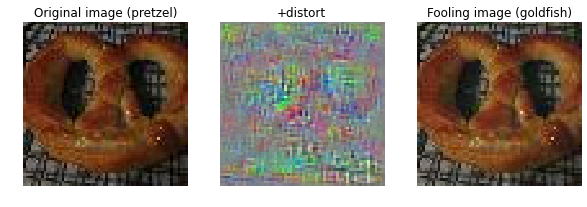

In [16]:
# Choose a random image that is correctly classified
idx = np.random.choice(np.nonzero(y_val_pred == y_val)[0])
img = X_val[idx:idx+1]
class_idx = 22 # Goldfish 22
confidence = 0.5
fooling_img = make_fooling_image(img, class_idx, model, step_size=1500, reg=0.000002, confidence=confidence)

# Check that the fooling image has probability above the threshold.
assert five_layer_convnet(fooling_img, model, return_probs=True)[0, class_idx] >= confidence, \
       'The ConvNet is not fooled.'

# Show the original image
plt.subplot(1, 3, 1)
plt.title('Original image (%s)' % class_names[y_val[idx]][0])
show_image(img)

# Show the difference between the original and fooling image
plt.subplot(1, 3, 2)
plt.title('+distort')
show_image(fooling_img - img, add_mean=False, rescale=True)

# Show the fooling image
plt.subplot(1, 3, 3)
plt.title('Fooling image (%s)' % class_names[class_idx][0])
show_image(fooling_img, rescale=True)

# Fooling image from random noise
Instead of starting from a correctly classified image, we can instead start our optimization from random noise. This will allow us to produce fooling images that do not look like anything to humans.

You should experiment with the scale of the initial random noise, the step size, the regularization, the confidence threshold, and the target class.

[ 0.01071417] 4.536187675
[ 0.01731451] 4.0562102683
[ 0.02697787] 3.61273833584
[ 0.0413487] 3.18571424621
[ 0.06249328] 2.77269617203
[ 0.09056885] 2.40164499031
[ 0.12535149] 2.07663356213
[ 0.16642759] 1.7931949469
[ 0.21195658] 1.55137384479
[ 0.26724812] 1.31957776917
[ 0.3326722] 1.10059765324
[ 0.41530864] 0.878733319127
[ 0.49851413] 0.696123335951
[ 0.56706133] 0.567287814401
[ 0.56706133]


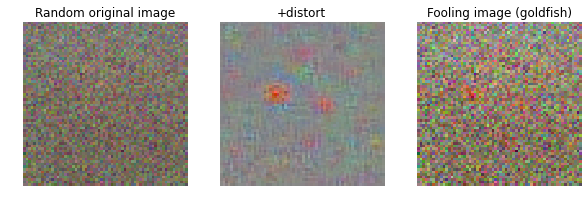

In [17]:
# Generate random noise to start
img = 20 * np.random.randn(1, 3, 64, 64)
class_idx = 22 # Goldfish
fooling_img = make_fooling_image(img, class_idx, model, step_size=2000, reg=0.000005, confidence=0.5)

# Check that the fooling image has probability above the threshold.
assert five_layer_convnet(fooling_img, model, return_probs=True)[0, class_idx] >= confidence, \
       'The ConvNet is not fooled.'

# Show the original image
plt.subplot(1, 3, 1)
plt.title('Random original image')
show_image(img)

# Show the difference between the original and fooling image
plt.subplot(1, 3, 2)
plt.title('+distort')
show_image(fooling_img - img, add_mean=False, rescale=True)

# Show the fooling image
plt.subplot(1, 3, 3)
plt.title('Fooling image (%s)' % class_names[class_idx][0])
show_image(fooling_img, rescale=True)